# SYSM6302 - Lab 4
Jonas Wagner, jrw200000

In [2]:
import networkx as nx
from numpy import *  # WHY!
import matplotlib.pyplot as plt
plt.ioff()
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
import asyncio
import random
import randomnet

The `randomnet` import statement provides functions to build local attachment and small world random networks. This small world network is slightly different from the version that is implemented in NetowrkX.

## Section 15.1.0: Small World Networks

This function generates a small world network, where `n` nodes are connected to `q` neighboring nodes "around the circle" and with probability `p` to all other nodes. Even though the `randomnet.py` file contains a very similar function, this version has some extra code to lay out the network in an intuitive way (with the nodes in a circle).

In [3]:
async def small_world(n,q,p,G=None,d3=None,x0=300,y0=300):
    '''
    q must be even
    '''
    if d3:
        d3.set_interactive(False)
    if G is None:
        G = D3Graph()
    for i in range(n):
        G.add_node(i)
        if d3:
            x = 200*cos(2*pi*i/n) + x0
            y = 200*sin(2*pi*i/n) + y0
            d3.position_node(i,x,y)
    # add the regular edges
    for u in range(n):
        for v in range(u+1,int(u+1+q/2)):
            v = v % n
            G.add_edge(u,v)

    if d3:
        d3.update()
        await asyncio.sleep(3)
        d3.set_interactive(True)

    # add the random edges
    for u in range(n):
        for v in range(u+1,n):
            if not G.has_edge(u,v):
                if random.random() <= p:
                    G.add_edge(u,v)

    return G

In [4]:
d3 = await d3nx.create_d3nx_visualizer()

websocket server started...networkx connected...visualizer connected...

Now with the visualizer running, we will visualize a small world network

In [9]:
G = D3Graph()
d3.set_graph(G)
G = await small_world(20,4,0.1,G,d3)

#### Diameter Observations
The original circular network appeared to have a diameter of approximently half the circle (so like 10) but when the random edges are added it dramatically decreased to around 3.

#### Diameter Calculation

Now let's plot the convergence of the small world effect.

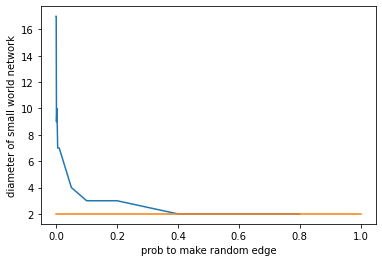

In [24]:
n = 100
P = [0,0.0001,0.001,0.0025,0.005,0.01,0.05,0.1,0.2,0.4,0.6,0.8]
x = []
y = []
for i, p in enumerate(P):
    G = randomnet.small_world_graph(n,6,p)
    x.append(p)
    y.append(nx.diameter(G))
    # calculate the diameter and store it for plotting below

## Plot the Convergence
plt.figure()
plt.plot(x,y)
plt.plot([0.0001,1],[(log10(n)),(log10(n))])
plt.xlabel('prob to make random edge')
plt.ylabel('diameter of small world network')
plt.show()

The addition of random edges being added to the network would add an additional path between nodes and in the best case, take the path that made up the original diameter and turn it to 2. If you randomly do this enough, there will eventlly make every node connected.

## Section 8.1-8.4.14: Fitting Power Law

The following helper functions provide easy access to the degree sequence and the degree and cumulative degree distributions.

In [28]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist

The following function, which you must complete, plots the degree distribution and calculates the power law coefficient, $\alpha$.

In [91]:
def calc_powerlaw(G,kmin=None):
    ddist = degree_distribution(G,normalize=True)
    cdist = cumulative_degree_distribution(G)
    k = arange(len(ddist))

    alpha = 1 # calculate using Newman (8.6)!
    sigma = 0 # calculate using Newman (8.7)!
    print( '%1.2f +/- %1.2f' % (alpha,sigma) )
    
    # Assign Values for Ploting
    xvalues = k;
    print(size(k))
    barheights = ddist # Degree Dist
    yvalues = cdist; # Cumulative Dist
    
    # Plot Degree Dist
    plt.figure(figsize=(8,12))
    plt.subplot(211)
    plt.bar(xvalues,barheights, width=0.8, bottom=0, color='b')
    plt.autoscale('True')
    
    # Plot cdist
    plt.subplot(212)
    plt.loglog(xvalues,yvalues)
    plt.grid(True)

In [92]:
calc_powerlaw(G)

1.00 +/- 0.00
795


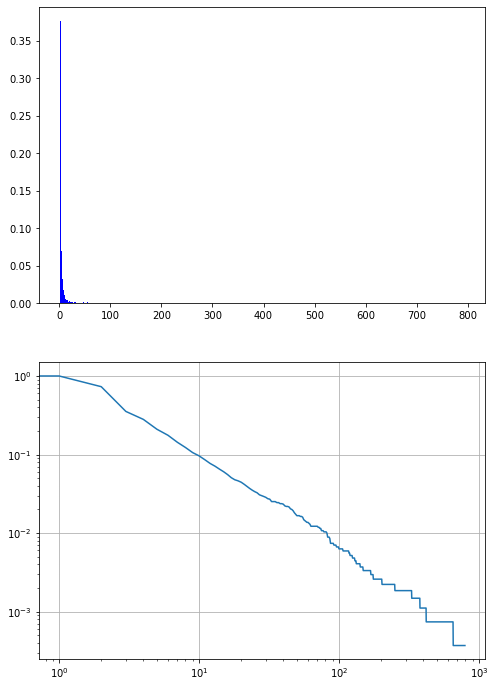

In [93]:
plt.show()

#### Degree Distribution calculation and ploting

In [33]:
# japanese.edgelist
G = nx.read_weighted_edgelist('japanese.edgelist',create_using=nx.DiGraph)
calc_powerlaw(G,kmin) # select kmin!
plt.show()

0.00 +/- 0.00


NameError: name 'xvalues' is not defined

In [30]:
# ca-HepTh.edgelist
G = nx.read_weighted_edgelist('ca-HepTh.edgelist',create_using=nx.Graph)
calc_powerlaw(G,kmin) # select kmin!
plt.show()

In [30]:
# soc-Epinions1.edgelist
G = nx.read_weighted_edgelist('soc-Epinions1.edgelist',create_using=nx.DiGraph)
calc_powerlaw(G,kmin) # select kmin!
plt.show()

NameError: name 'kmin' is not defined

## Giant Component

## Degree Distributions of Random Network Models

In [25]:
N = 5000

### Erdos-Renyi

In [10]:
G = nx.erdos_renyi_graph(N,p)

### Small-World

In [11]:
G = randomnet.small_world_graph(N,q,p)

### Barabasi-Albert

In [12]:
G = nx.barabasi_albert_graph(N,m)

### Local Attachment

In [13]:
G = randomnet.local_attachment_graph(N,m,r)

### Duplication Divergence

In [14]:
G = nx.duplication_divergence_graph(N,s)

## Fitting Random Models

In [15]:
G = nx.read_weighted_edgelist('ca-HepTh.edgelist')
n = G.number_of_nodes()
m = G.number_of_edges()

## Configuration Model

In [16]:
G = nx.read_weighted_edgelist('texas_road_sample.edgelist')
G = nx.read_weighted_edgelist('international_airports.edgelist')